In [96]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def make_causal(x, y):
    x, y = np.array(x), np.array(y)
    y[x < 0] = 0
    return y

def gaussian(x, center, FWHM, normalisation_coeffient = None):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    if normalisation_coeffient == None:
        normalisation_coeffient = 0.5/np.sum(np.abs(np.exp(exponent))) #1 /(sigma *(2*np.pi)**0.5)
    return normalisation_coeffient *np.exp(exponent)
    
def convolve(array, xs, convol_func): # Convolves an array with a function.
    assert len(array) == len(xs), "All values in the array must have a corrisponding x value."

    summation = np.zeros_like(xs, dtype= np.complex128)
    for n, y in enumerate(xs):
        convol_array = convol_func(xs-y)
        summation = summation + array[n]*convol_array

    sort = np.argsort(xs)
    unsort = np.argsort(sort)
    normalisation = np.diff(xs[sort], append= 2*xs[sort][-1] -xs[sort][-2]) # Extrapolate the last value.
    normalisation = normalisation[unsort] # When approximatating an intergral to the sum of many rectangles, we must find the area by multiplying by the width of the rectangles.
    
    return normalisation *summation

def hilbert_transform(array, xs):
    cauchy_kernel = lambda t: np.nan_to_num(1/(np.pi*t), nan=0, posinf=0, neginf=0) # replace all invalid values with 0
    return convolve(array, xs, cauchy_kernel) # We don't need the normalisation constant of 1/np.pi that you would find in a continuous integral because we have already applied the descrieteised normalisation.

In [4]:
array_length = 10000 #in pixels
central_wavenumber = 3e-3 #in pixels^-1
FWHM_wavenumber = 5e-4 #in pixels^-1

print(1/central_wavenumber) # effective wavelength in pixels

333.3333333333333


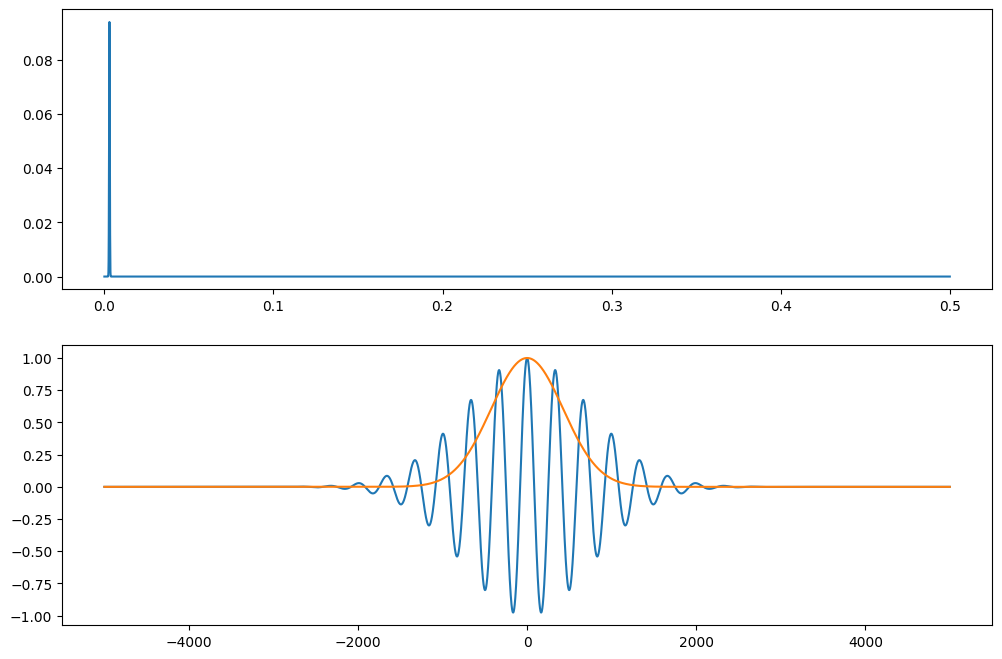

In [5]:
wavenumbers = np.fft.rfftfreq(array_length, 1)
amplitudes = gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)
intensity = np.fft.irfft(amplitudes, norm= "forward")
intensity = np.fft.fftshift(intensity)
displacement = np.arange(array_length) - array_length//2
intensity = np.add(intensity, 1j*gaussian(displacement, 0, 1000, 1)) #add an imaginary component just to see what happens

fig, axs = plt.subplots(2,1, figsize= (12,8))

axs[0].plot(wavenumbers, amplitudes)
#axs[0].set(xlim= (central_wavenumber-FWHM_wavenumber, central_wavenumber+2*FWHM_wavenumber))
axs[1].plot(displacement, intensity.real)
axs[1].plot(displacement, intensity.imag)

plt.show()

### HERBERT TRANSFORM

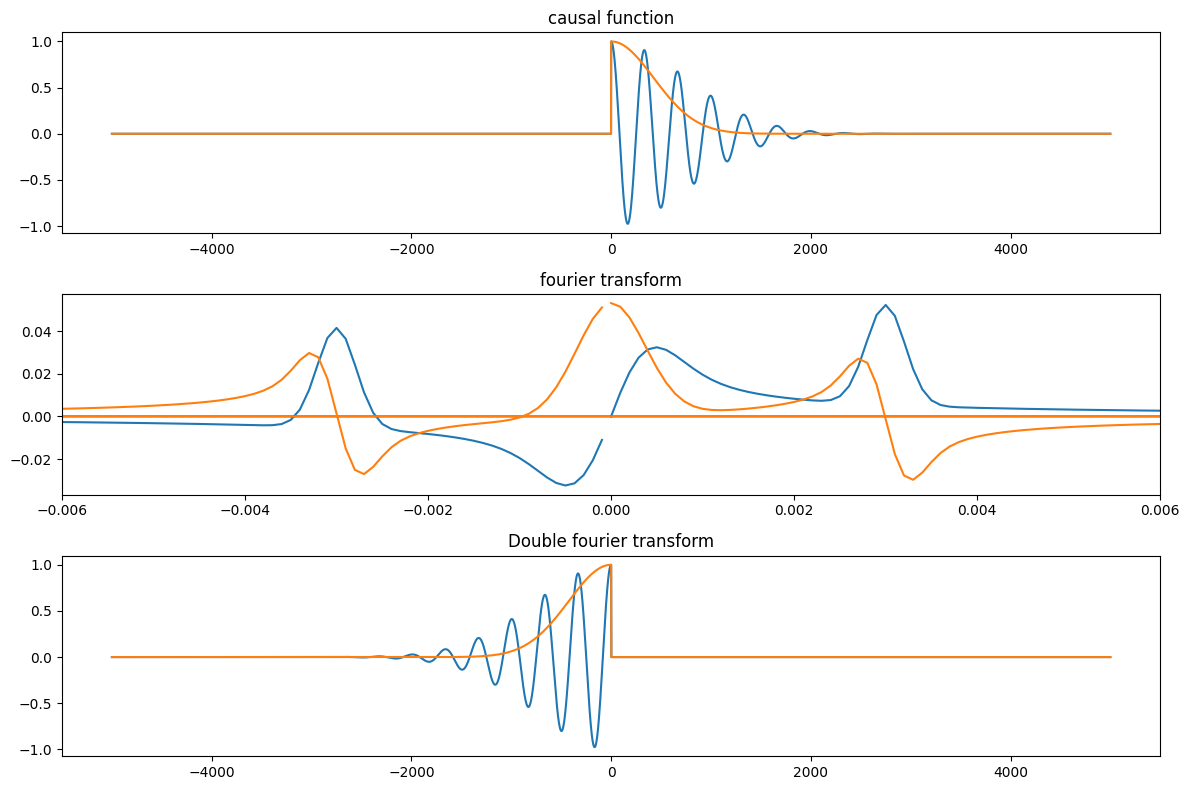

In [6]:
intensity = make_causal(displacement, intensity)
amplitudes = np.fft.fft(np.fft.ifftshift(intensity), norm= "forward") # the fft ALWAYS starts at zero. Negative displacements should be wrapped around to the end.
wavenumbers = np.fft.fftfreq(array_length, 1)
double_fourier = np.fft.fftshift(np.fft.fft(amplitudes, norm= "backward"))

fig, axs = plt.subplots(3,1, figsize= (12,8))

axs[0].plot(displacement, intensity.real)
axs[0].plot(displacement, intensity.imag)
axs[0].set(title= "causal function")
axs[1].plot(wavenumbers, amplitudes.real)
axs[1].plot(wavenumbers, amplitudes.imag)
axs[1].set(xlim= (-2*central_wavenumber, 2*central_wavenumber), title= "fourier transform")
axs[2].plot(displacement, double_fourier.real)
axs[2].plot(displacement, double_fourier.imag)
axs[2].set(title= "Double fourier transform")

plt.tight_layout()
plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_23152\1659429987.py:29: RuntimeWarning: divide by zero encountered in divide
  cauchy_kernel = lambda t: np.nan_to_num(1/(np.pi*t), nan=0, posinf=0, neginf=0) # replace all invalid values with 0


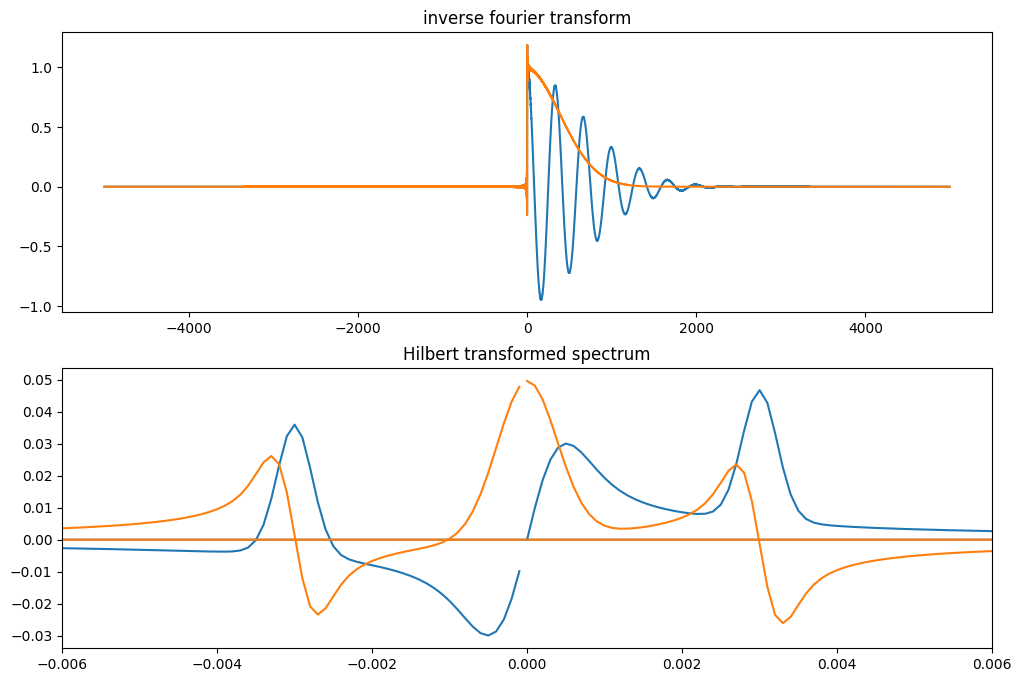

In [7]:
#amplitudes = np.fft.fftshift(amplitudes) #optionally put it in order.
#wavenumbers = np.fft.fftshift(wavenumbers)

amplitudes_hilbert = -1j *hilbert_transform(amplitudes, wavenumbers)
intensity_hilbert = np.fft.fftshift(np.fft.ifft(amplitudes_hilbert, norm= "forward"))

fig, axs = plt.subplots(2,1, figsize= (12,8))

axs[0].plot(displacement, intensity_hilbert.real)
axs[0].plot(displacement, intensity_hilbert.imag)
axs[0].set(title= "inverse fourier transform")
axs[1].plot(wavenumbers, amplitudes_hilbert.real)
axs[1].plot(wavenumbers, amplitudes_hilbert.imag)
axs[1].set(xlim= (-2*central_wavenumber, 2*central_wavenumber), title= "Hilbert transformed spectrum")

plt.show()

In [37]:
a = np.array([np.nan, 1, 2, 3, np.nan])

a[~np.isnan(a)]

array([1., 2., 3.])

In [35]:
np.isnan([np.nan, 10]).any()

True

### KRAMERS-KRONIG

In [164]:
def lim(function, target, l0, r0):
    converging = True

    while converging:
        l1, r1 = np.mean([l0, target]), np.mean([r0, target])
        l2, r2 = np.mean([l1, target]), np.mean([r1, target])

        fl0, fr0 = function(l0), function(r0)
        fl1, fr1 = function(l1), function(r2)
        fl2, fr2 = function(l2), function(r2)

        delta_l0, delta_r0 = np.abs(fl1 -fl0), np.abs(fr1 -fr0)
        delta_l1, delta_r1 = np.abs(fl2 -fl1), np.abs(fr2 -fr1)

        if delta_l1 < delta_l0 and delta_r1 < delta_r0: #limit is converging :)
            l0, r0 = l1, r1
        else: #limit is diverging >:(
            converging = False

    return np.mean([fl0, fr0])

def kramers_kronig(omega, rho):
    assert len(omega) == len(rho), "All values in the function must have a corrisponding frequency."
    N = len(omega)

    sort = np.argsort(omega)
    unsort = np.argsort(sort)
    delta_omega = np.diff(omega[sort], append= 2*omega[sort][-1] -omega[sort][-2]) # Extrapolate the last value.
    delta_omega = delta_omega[unsort] # When approximatating an intergral to the sum of many rectangles, we must find the area by multiplying by the width of the rectangles.

    summation = np.zeros(N)
    integrand = np.zeros(N)

    for x, dx, rho_x, n in zip(omega, delta_omega, rho, np.arange(N)):
        numerator = -omega *np.log(rho_x /rho)
        denominator = omega**2 -x**2
        integrand= numerator/denominator

        ###### SOLVING LIMIT #####
        rho_func = lambda y: np.interp(y, omega, rho)
        integrand_func = lambda y: -x *np.log(rho_func(y)/rho_x) /(x**2 -y**2) # I have used x as the frequency and y as the integral variable. (instead of omega and x)

        integrand[n] = lim(integrand_func, x, x -dx, x +dx)
        print(integrand[n-1:n+2])

        summation += integrand *dx

    return 2/np.pi *summation

C:\Users\syf83691\AppData\Local\Temp\ipykernel_23152\2995657088.py:39: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator


[]
[   0.         4210.20863345 4459.14766173]
[2229.57383087 2471.1432338  2435.76323971]
[1623.84215981 1688.61228087 1679.98924056]
[1259.99193042 1292.46354233 1293.92437897]
[1035.13950318 1057.72650431 1063.66934456]
[886.39112047 905.15813897 913.51306025]
[783.0111945  800.19428994 810.09665936]
[708.83457694 725.46310657 736.53298806]
[654.69598939 671.34588191 683.42968707]
[615.08671836 632.1489818  645.21611215]
[586.56010195 604.35527316 618.45480871]
[566.91690798 585.75467104 600.99910727]
[554.76840671 574.98800858 591.55188153]
[549.29817571 571.30641484 589.4361945 ]
[550.1404482  574.45890212 594.49535821]
[557.33939832 584.6762152  607.09582231]
[571.38430335 602.76016315 628.25289444]
[593.34995586 630.351849   659.98147819]
[625.24561092 670.59293388 706.15186637]
[670.84427305 729.58122291 774.27877599]
[737.40835808 818.41626162 877.37724815]
[ 837.49646414  951.33622113 1028.67351755]
[ 983.948582   1127.86842466 1215.86720515]
[1165.2060716  1300.80121571 1371

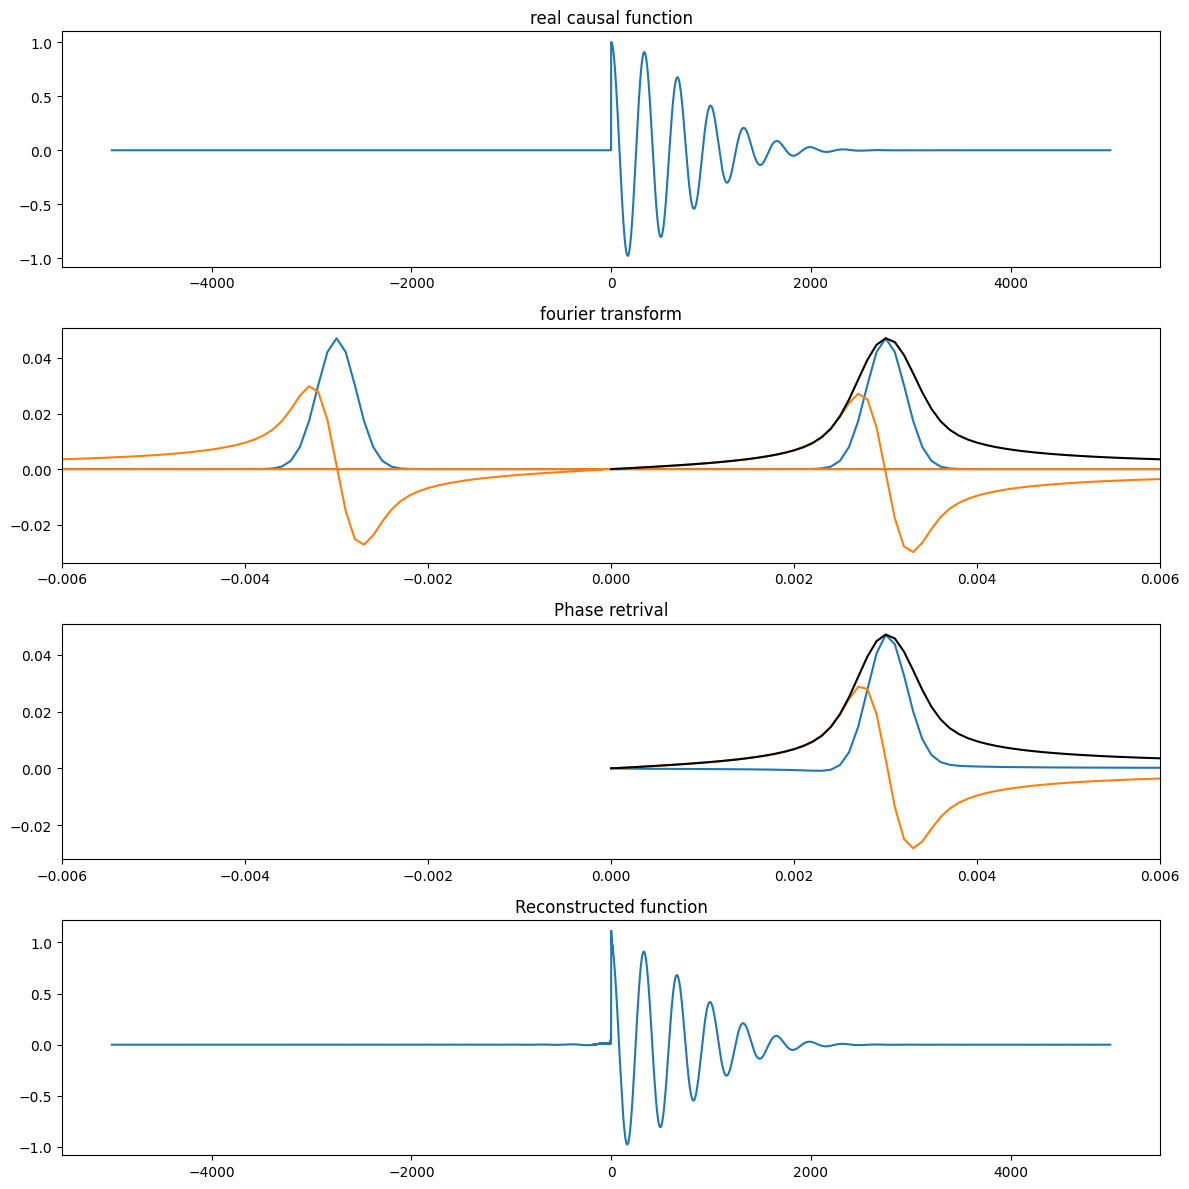

In [165]:
intensity = intensity.real
amplitudes = np.fft.fft(np.fft.ifftshift(intensity), norm= "forward") # the fft ALWAYS starts at zero. Negative displacements should be wrapped around to the end.
wavenumbers = np.fft.fftfreq(array_length, 1)

fig, axs = plt.subplots(4,1, figsize= (12,12))

axs[0].plot(displacement, intensity)
axs[0].set(title= "real causal function")
axs[1].plot(wavenumbers, amplitudes.real)
axs[1].plot(wavenumbers, amplitudes.imag)
axs[1].set(xlim= (-2*central_wavenumber, 2*central_wavenumber), title= "fourier transform")

amplitudes_kk = np.abs(amplitudes)[wavenumbers >= 0] #throw away all phase infomation
wavenumbers = wavenumbers[wavenumbers >= 0]

axs[1].plot(wavenumbers, np.abs(amplitudes_kk), color= "k")

phase = kramers_kronig(wavenumbers, amplitudes_kk) # find the phase using kk
amplitudes_kk = amplitudes_kk *np.exp(1j *phase)

axs[2].plot(wavenumbers, amplitudes_kk.real)
axs[2].plot(wavenumbers, amplitudes_kk.imag)
axs[2].set(xlim= (-2*central_wavenumber, 2*central_wavenumber), title= "Phase retrival")
axs[2].plot(wavenumbers, np.abs(amplitudes_kk), color= "k")

intensity_kk = np.fft.ifftshift(np.fft.irfft(amplitudes_kk, n= array_length, norm= "forward"))

axs[3].plot(displacement, intensity_kk)
axs[3].set(title= "Reconstructed function")

plt.tight_layout()
plt.show()